# Evaluate agent performance across runs in an experiment

Using the [MLflow tracking API](https://www.mlflow.org/docs/latest/tracking.html).

In [1]:
%config Completer.use_jedi = False
import os
from pathlib import Path

import mlflow

import matplotlib.pyplot as plt

from clovek_ne_jezi_se.agents import RandomPlayer

## Helper function

Convert run parameter dictionary into disjuntive ("and") filter query string, to be used with [mlflow.search_runs](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.search_runs).

TODO read in from json parameter file, rather than copy pasting dict from script?

In [2]:
def dict_to_conjunctive_filter_equality_string(a_dict, tracking_type: str):
    """
    Convert a dictionary of a given tracking type--params, metrics, tags--
    to a conjunctive (i.e. 'and') filter string of equality conditions.
    
    Lists are converted to comma-separated strings.
    """
    conditions = []
    for key, value in a_dict.items():
        if isinstance(value, list):
            value = ','.join(value)
        conditions.append(tracking_type + '.' + key + '="' + str(value) + '"')
    return " and ".join(conditions)
        
    return (
        "params.agents = 'RandomPlayer,RandomPlayer,RandomPlayer,RandomPlayer'"
        " and params.main_board_section_length = 1"
    )

def test_dict_to_conjunctive_filter_equality_string():
    player_names = ['red', 'blue', 'green', 'yellow']
    players = [RandomPlayer(name=name, print_game_state=False) for name in player_names]

    main_board_section_length = 1
    agents = [player.__class__.__name__ for player in players]

    run_params = dict(
        agents=','.join(agents),
        main_board_section_length=main_board_section_length
    )
    
    filter_string = dict_to_conjunctive_filter_equality_string(run_params, tracking_type='params')
    expected = (
        'params.agents="RandomPlayer,RandomPlayer,RandomPlayer,RandomPlayer"'
        ' and params.main_board_section_length="1"'
    )
    try:
        assert filter_string == expected
    except AssertionError as err:
        print(err, filter_string, ' is not ', expected)
    
test_dict_to_conjunctive_filter_equality_string()

## Get winner counts

Based on runs of `scripts/play.py`.

First we define a filter query string, then use [mlflow.search_runs](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.search_runs) to get run results as a pandas dataframe.

In [3]:
player_names = ['red', 'blue', 'green', 'yellow']
players = [RandomPlayer(name=name, print_game_state=False) for name in player_names]

main_board_section_length = 1
pieces_per_player = 4
number_of_dice_faces = 6
agents = [player.__class__.__name__ for player in players]

run_params = dict(
    agents=','.join(agents),
    main_board_section_length=main_board_section_length,
    pieces_per_player=pieces_per_player,
    number_of_dice_faces=number_of_dice_faces
)
filter_string = dict_to_conjunctive_filter_equality_string(run_params, 'params')

# mlflow.search_runs seemingly must be run from parent directory of mlruns
os.chdir(os.environ['RUNS_PARENT_DIR'])
runs = mlflow.search_runs(filter_string=filter_string)

# Remove runs with no winner
mask_winner_isna = runs['metrics.winner_idx'].isna()
runs = runs[~mask_winner_isna]
winner_idxes = runs['metrics.winner_idx'].astype(int)

# Calculate winner counts
winner_counts = winner_idxes.value_counts()
names = [agents[idx] + '_' + str(idx) for idx in winner_counts.index]
counts = winner_counts.values.astype(int)
winner_counts

1    31
0    24
3    24
2    21
Name: metrics.winner_idx, dtype: int64

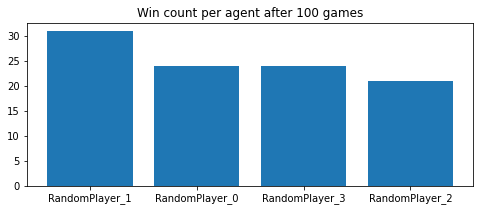

In [4]:
plt.figure(figsize=(8,3))
plt.bar(names, counts)
plt.title(f'Win count per agent after {winner_counts.sum()} games')
plt.xticks(names, names);